In [94]:
import pandas as pd
from textblob import TextBlob
import time
import os
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import streamlit as st 
import folium
from streamlit_folium import folium_static

In [95]:
df1 = pd.read_excel("../resources/dataset/final_clean_data.xlsx", sheet_name="Clean_Candidate_Donor_data")

In [96]:
df1.head()

,ID,Age,Horodateur,Niveau_scolaire,Genre_,Situation_Matrimoniale_(SM),Profession_,Arrondissement_de_résidence_,Quartier_de_Résidence_,Nationalité_,Religion_,A-t-il_(elle)_déjà_donné_le_sang_,Taux_d’hémoglobine_,ÉLIGIBILITÉ_AU_DON.
0,DONOR_1842,24,46:44.9,3,1,0,Etudiant (e),Douala 3,Yassa,Camerounaise,Chretien (Catholique),0,13.895459,1
1,DONOR_1843,23,44:19.0,3,1,0,Sans Emplois,Pas Précisé,Pas Précisé,Camerounaise,Chretien (Catholique),1,10.800000,0
2,DONOR_1844,41,46:54.3,0,1,2,Tailleur,Douala 1,NEW BELL,Camerounaise,Pas Précisé,0,13.895459,0
3,DONOR_1845,24,29:29.7,3,1,0,Etudiant,Douala 5,Ange raphael,Camerounaise,Musulman,0,15.000000,1
4,DONOR_1846,30,47:47.4,2,1,0,Militaire,Douala (Non précisé ),Beedi,Camerounaise,Adventiste,1,13.895459,1


In [97]:
df2 = pd.read_excel("../resources/dataset/final_clean_data.xlsx", sheet_name="Clean_Donor_Data")

In [98]:
df2.head()

,Sexe,Age,Type de donation,Groupe Sanguin ABO / Rhesus,Phenotype,Date
0,1,26,F,B+,"RH-2, RH+4, RH-3, RH+5, -kell1",2020-07-16
1,1,24,F,O+,"RH-2, RH+4, RH-3, RH+5, -kell1",2020-07-16
2,1,41,F,A+,"RH+2, RH+4, RH-3, RH+5, -kell1",2020-07-17
3,1,20,F,O+,"RH-2, RH+4, RH-3, RH+5, -kell1",2020-07-17
4,1,34,F,O+,"RH-2, RH+4, RH+3, RH+5, -kell1",2020-07-17


In [99]:

def donation_sentiment(row):
    if row["A-t-il_(elle)_déjà_donné_le_sang_"] == "Oui":
        if pd.notna(row["Si oui preciser la date du dernier don."]):
            return "Positive"  # Recent donor
        else:
            return "Neutral"  # Donated before but no recent record
    return "Negative"  # Never donated

df1["Sentiment de Don"] = df1.apply(donation_sentiment, axis=1)


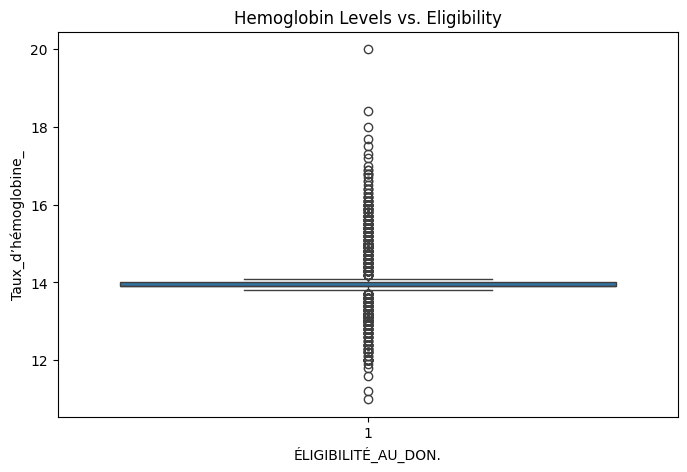

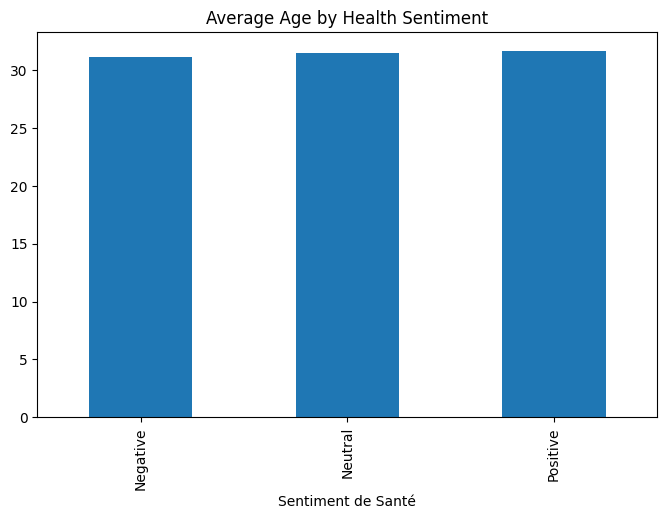

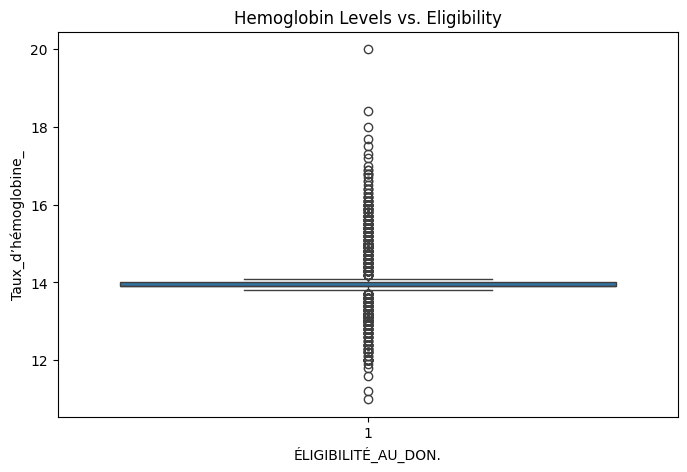

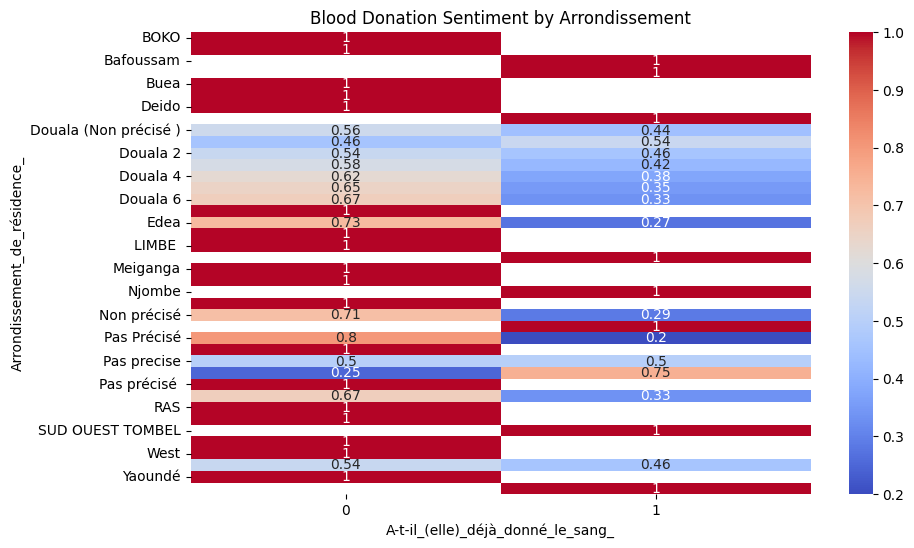

In [100]:

geo_sentiment = df1.groupby("Arrondissement_de_résidence_")["A-t-il_(elle)_déjà_donné_le_sang_"].value_counts(normalize=True).unstack()

# Heatmap for visualization
plt.figure(figsize=(10, 6))
sns.heatmap(geo_sentiment, cmap="coolwarm", annot=True)
plt.title("Blood Donation Sentiment by Arrondissement")
plt.show()

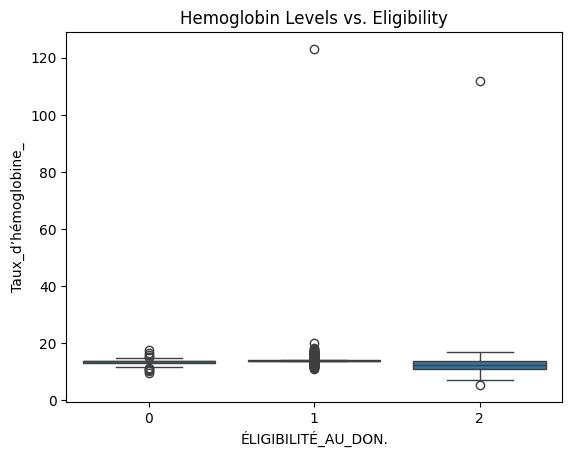

In [101]:
# Convert "Taux d’hémoglobine" to numeric, forcing errors to NaN
df1["Taux_d’hémoglobine_"] = pd.to_numeric(df1["Taux_d’hémoglobine_"], errors='coerce')


# Now plot
sns.boxplot(x="ÉLIGIBILITÉ_AU_DON.", y="Taux_d’hémoglobine_", data=df1)
plt.title("Hemoglobin Levels vs. Eligibility")
plt.show()


In [102]:
# Check the first few rows and summary statistics for 'Taux_d’hémoglobine_'
df1[['Taux_d’hémoglobine_']].head()  # Display first few rows
df1['Taux_d’hémoglobine_'].describe()  # Summary statistics


count    1846.000000
mean       13.895459
std         3.594065
min         5.500000
25%        13.700000
50%        13.895459
75%        13.895459
max       123.100000
Name: Taux_d’hémoglobine_, dtype: float64

In [103]:


# Define sentiment based on hemoglobin level with more dynamic outlier handling
def health_sentiment(row):
    hemoglobin_value = row['Taux_d’hémoglobine_']
    
    # Handle missing or invalid hemoglobin values
    if pd.isnull(hemoglobin_value) or hemoglobin_value <= 0:
        return "Invalid"  # Mark as invalid for extreme values or outliers
    
    # Apply sentiment logic based on hemoglobin value
    if hemoglobin_value > 14:  # Generally, higher than 14 g/dL can be considered "positive"
        return "Positive"
    elif 12 <= hemoglobin_value <= 14:  # Hemoglobin between 12 and 14 g/dL considered neutral
        return "Neutral"
    else:  # If it's less than 12 g/dL, it’s generally "negative" sentiment
        return "Negative"

# Filter out extreme outliers or invalid values (if any)
df1 = df1[df1['Taux_d’hémoglobine_'] <= 20]  # Adjust the threshold if necessary

# Apply the health sentiment function to the dataset
df1['Sentiment de Don'] = df1.apply(health_sentiment, axis=1)

# Check if the new column was successfully added
st.write(df1[['Taux_d’hémoglobine_', 'Sentiment de Don']].head())


2025-03-25 13:45:06.202 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.203 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [104]:
df1['Sentiment de Don'].value_counts()

Sentiment de Don
Neutral     1372
Positive     367
Negative     105
Name: count, dtype: int64

In [105]:
# **Streamlit Dashboard**
st.title(" Blood Donation Sentiment Analysis")

# Sidebar filter for eligibility
eligibility_filter = st.sidebar.selectbox("Filter by Eligibility", 
                                          df1["ÉLIGIBILITÉ_AU_DON."].unique())

filtered_df = df1[df1["ÉLIGIBILITÉ_AU_DON."] == eligibility_filter]

st.write(f"###  Hemoglobin Levels for {eligibility_filter} Donors")


2025-03-25 13:45:06.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.231 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.231 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.232 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [106]:
#  **Boxplot for Hemoglobin vs. Eligibility**
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(x="ÉLIGIBILITÉ_AU_DON.", y="Taux_d’hémoglobine_", data=filtered_df, ax=ax)
plt.title("Hemoglobin Levels vs. Eligibility")
st.pyplot(fig)

2025-03-25 13:45:06.292 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.378 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.378 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [107]:
# **Compare Other Health Factors (Poids, Taille)**
st.write("### Impact of Health Factors on Donation Eligibility")

2025-03-25 13:45:06.399 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.400 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.401 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:06.401 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [109]:
fig, ax = plt.subplots(figsize=(8,5))

# Group by 'Sentiment de Santé' and plot the mean of 'Age'
filtered_df.groupby('Sentiment de Don')['Age'].mean().plot(kind='bar', ax=ax)

plt.title("Average Age by Health Sentiment")
st.pyplot(fig)

st.write("Insights: The average age of individuals might differ depending on their health sentiment.")


2025-03-25 13:45:18.606 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:18.704 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:18.705 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:18.705 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:18.706 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:18.706 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:18.707 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [110]:
# **Save Results**
df1.to_csv("sentiment_analysis_results.csv", index=False)
st.write(" Data saved successfully!")

2025-03-25 13:45:21.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:21.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:21.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 13:45:21.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
